# Image search based on visual similarity

## Basic 1.0 version of the code


In [10]:
# Loading required modules

from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import os
import numpy as np
import time
import random
import matplotlib.pyplot as plt

In [11]:
# Define constants

IMGS_PATH = "smalldata\\images\\"

# Size as per VGG16 input layer size
IMGS_WIDTH, IMGS_HEIGHT = 224, 224 

#Kept small value for quick demo
DATA_SIZE = 1000

In [12]:
# load VGG16 model with weights from imagenet dataset
vgg_model = vgg16.VGG16(weights='imagenet')

# Take only the last layer which contains the feature vector
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# Get summury of feat_extractor architecture
feat_extractor.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [13]:
files = [IMGS_PATH + x for x in os.listdir(IMGS_PATH) if "jpg" in x]

files = files[:DATA_SIZE]
print("Total images:",len(files))

Total images: 1000


In [14]:
imported_imgs = []

for file in files:
    filename = file
    test_img = load_img(filename, target_size=(IMGS_WIDTH, IMGS_HEIGHT))
    np_img = img_to_array(test_img)
    # Add additional axis so that first dimension becomes number images added
    image_batch = np.expand_dims(np_img, axis=0)
        
    imported_imgs.append(image_batch)

# Create vertically stacked images
imgs = np.vstack(imported_imgs)

# Use custom function given by Keras for pre-processing data compatible with ImageNet
processed_imgs = preprocess_input(imgs.copy())

print('Input image array processing done!')
print('Array Size:', processed_imgs.shape)

Input image array processing done!
Array Size: (1000, 224, 224, 3)


In [15]:
# extract the images features

start_time = time.process_time()

# Run the feature extractor on all stacked input images
imgs_features = feat_extractor.predict(processed_imgs)

print("All input image features successfully extracted!")
print('Features matrix size:', imgs_features.shape)
end_time = time.process_time()
print('Time required for extracting features:',(end_time - start_time), 'sec')

All input image features successfully extracted!
Features matrix size: (1000, 4096)
Time required for extracting features: 1427.5625 sec


In [16]:
# number of most similar images to retrieve
# One extra result will be distance calculated with test image itself thus 11
N_CLOSEST_IMGS = 11 

nbrs = NearestNeighbors(n_neighbors=N_CLOSEST_IMGS,metric='cosine')

# Fits the data to the KNN model, also makes querying faster
nbrs.fit(imgs_features)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                 radius=1.0)

In [17]:
def get_similar_images(test_img_index):  
     
    start_time = time.process_time()
    # Get the test image feature vector
    
    # This is a similar process that of training phase
    vgg_model = vgg16.VGG16(weights='imagenet')
    
    feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
    test_img_resized = load_img(files[test_img_index], target_size=(IMGS_WIDTH, IMGS_HEIGHT))
    np_img = img_to_array(test_img_resized)
    
    # This img_batch contains feature vector for test image only
    img_batch = np.expand_dims(np_img, axis=0)
    processed_image = preprocess_input(img_batch.copy())

    # Get the extracted features test image
    test_img_feat_vec = feat_extractor.predict(processed_image)
    
    # Calculate closes N_CLOSEST_IMGS feature vectors (and images) to test feature vector
    distances, indices = nbrs.kneighbors(test_img_feat_vec)

    end_time = time.process_time()
    
    print('Execution time for search:',(end_time-start_time),'sec')
    # Display Test image
    print("***********************************************************************")
    print("Test Image :",test_img_index)
    test_img = load_img(files[test_img_index])
    plt.imshow(test_img)
    plt.show()

    # Display matching images results
    print("***********************************************************************")
    print("Image results based on KNN similarity:")
    # Create a grid of 2x5 to display 10 matching images properly
    f, axarr = plt.subplots(2,5)
    plt.subplots_adjust(right=1.5,hspace=0.5)

    for i in range(1,N_CLOSEST_IMGS):
        res = load_img(files[indices[0][i]])
        axarr[(i-1)//5][(i-1)%5].imshow(res)
        axarr[(i-1)//5][(i-1)%5].set_title(str(round(distances[0][i],4)))

Execution time for search: 9.171875 sec
***********************************************************************
Test Image : 357


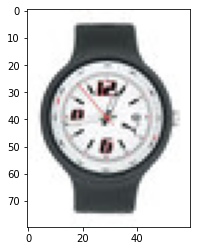

***********************************************************************
Image results based on KNN similarity:


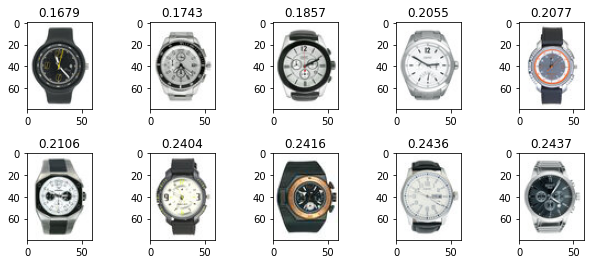

In [20]:
# Get a random test image from given dataset and retrive N_CLOSEST_IMGS similar images
# Alternatively we can also send a completely new test image which is not part of database
test_img_index = random.randint(0,DATA_SIZE)

# Function to search the input test image and display similar results
get_similar_images(test_img_index)